In [1]:

from __future__ import print_function, division
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.nn import init
import torch.nn.functional as F
import functools
import numpy as np
import torchvision
from torchvision import transforms, datasets, models
import os
import time

from torchsummary import summary

from tensorboardX import SummaryWriter

import matplotlib.pyplot as plt

In [2]:
# Training settings
batch_size = 1

In [3]:
#%% 이걸 사용하자
# t_image_size=224
transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
transform_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop((224,224)),
    transforms.ToTensor()
])
transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

data_dir = '/media/lee/E61C94F21C94BECD/place_dataset/15_Scene/15'
# data_dir = '/media/lee/E61C94F21C94BECD/place_dataset/Places2/data_class50/'


train_image_datasets = torchvision.datasets.ImageFolder(os.path.join(data_dir),
                                     transform = transform_train)
val_image_datasets = torchvision.datasets.ImageFolder(os.path.join(data_dir),
                                     transform = transform_val)
test_image_datasets = torchvision.datasets.ImageFolder(os.path.join(data_dir),
                                     transform = transform_test)


dataset_size = len(train_image_datasets)
print('total size:', dataset_size)
class_names_train = train_image_datasets.classes
class_names_val = val_image_datasets.classes
class_names_test = test_image_datasets.classes
# print(class_names)
print('# of train class: ', len(class_names_train))
print('# of valid class: ', len(class_names_val))
print('# of test class : ', len(class_names_test))
## SPLIT DATASET
train_split= 0.30
validate_split = 0.20
test_split = 0.50
train_size = int(train_split * dataset_size)
validation_size = int(validate_split * dataset_size)
test_size = int(dataset_size - train_size - validation_size)

# ########### CURRENTLY DOING THIS, WHICH WORKS ###########

indices = list(range(dataset_size))
np.random.shuffle(indices)
train_indices = indices[:train_size]
temp = int(train_size+validation_size)
val_indices = indices[train_size:temp]
test_indices = indices[temp:]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(
    train_image_datasets, batch_size=batch_size, sampler=train_sampler,
    num_workers=4)
valid_loader = torch.utils.data.DataLoader(
    val_image_datasets, batch_size=batch_size, sampler=valid_sampler,
    num_workers=4)
test_loader = torch.utils.data.DataLoader(
    test_image_datasets, batch_size=batch_size, sampler=test_sampler,
    num_workers=4)

dataloaders = {
    'train': train_loader,
    'valid': valid_loader,
    'test' : test_loader
}
image_datasets = {
    'train': train_sampler,
    'valid': valid_sampler,
    'test' : test_sampler
}

dataset_sizes ={
    'train': len(image_datasets['train']),
    'valid': len(image_datasets['valid']),
    'test' : len(image_datasets['test'])
}

# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# print('train_class:' len(train_image_datasets.classes))

print('train_size: ',dataset_sizes['train'], '\nvalid_size: ',dataset_sizes['valid'], 
      '\ntest_size : ',dataset_sizes['test'])
# class_names = image_datasets['train'].classes
# print(class_names)
# print('len class: ', len(class_names))



total size: 900
# of train class:  15
# of valid class:  15
# of test class :  15
train_size:  270 
valid_size:  180 
test_size :  450


In [4]:
from ResidualUnit import ResidualBlock
from ASPP_place_edit import ASPP_places
# from attention_module import Attention_step1

In [15]:
class Attention_place(nn.Module):
    def __init__(self):
        super(Attention_place, self).__init__()
        self.begin_residual_blocks = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=7, stride = 2, padding = 3),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d(kernel_size=3, stride=2, padding = 1)
        )#56x56
        self.trunk_first_conv = nn.Sequential(
            nn.Conv2d(64,64, kernel_size=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.2)
        )#56x56
        self.trunk = nn.Sequential(
            ResidualBlock(64, 256, 1),
            ResidualBlock(256, 256, 1)
        )#56x56
        self.trunk_last_conv = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size = 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2)            
        )#56x56
        self.trunk_residual = nn.Sequential(
            nn.Conv2d(64,256,1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2)
#             nn.MaxPool2d(kernel_size=3, stride = 2, padding = 1)
        )
#         resnet = ResNet18()
#         self.num_classes = len(class_names)
#         self.resnet = nn.Sequential(*list(resnet.children())[:-2])#8x8

        self.aspp = ASPP_places()
        self.mask_first_conv = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=1, stride = 2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2)
        )#28x28
        self._last_conv = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=1, stride = 2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(512, 2048, kernel_size=1, stride = 2),
            nn.BatchNorm2d(2048),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d(kernel_size=3, stride = 2, padding = 1)
        )#7x7
        
        
        self.mpool = nn.Sequential(
            nn.BatchNorm2d(2048),
            nn.LeakyReLU(negative_slope=0.2),
            nn.AvgPool2d(kernel_size=7, stride=1)
        )
        self.fc = nn.Linear(2048, 15)
    def forward(self, x):
        h = int(x.size()[2] / 4)
        w = int(x.size()[3] / 4)
#         print('h:',h, 'w:',w)
        x1 = self.begin_residual_blocks(x)#56x56
#         print(x1.shape)
#         print(x1.shape)
#################trunk_part#################
        out_trunk1 = self.trunk_first_conv(x1)#56x56
        out_trunk2 = self.trunk(out_trunk1)#56x56
        out_trunk3 = self.trunk_last_conv(out_trunk2)#56x56
#         out_trunk = F.upsample(out_trunk, size=(h,w), mode="bilinear")#56x56x256
        out_trunk4 = out_trunk3 + self.trunk_residual(x1)#56x56
#         out_trunk = F.softmax(out_trunk)
#################trunk_part#################        

#################mask_part#################
        feature_map = self.mask_first_conv(x1)#28x28x256
        mask1 = self.aspp(feature_map)#28x28x256
#         print(mask.shape)
        mask2 = F.upsample(mask1, size=(h, w), mode="bilinear") #56x56x256
#         mask = F.softmax(mask)
#################mask_part#################
        out1 = (1 + mask2) * out_trunk4 #56x56x256
#         print(out.shape)
        out2 = self._last_conv(out1)#7x7x512
#         print(out.shape)
        out3 = self.mpool(out2)#1x1x512
#         print(out.shape)
        out4 = out3.view(out3.size(0),-1)
#         print(out.shape)
        out = self.fc(out4)

        return out, x1, out_trunk1, out_trunk2, out_trunk3, feature_map, mask1, mask2, out1, out2, out3, out4
        

In [16]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:         # Conv weight init
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:  # BatchNorm weight init
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [17]:
model = Attention_place()

In [18]:
model.apply(weights_init)

Attention_place(
  (begin_residual_blocks): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (trunk_first_conv): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (trunk): Sequential(
    (0): ResidualBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False

In [19]:
# device = torch.device('cuda:0')
# torch.cuda.set_device(device)
# model.cuda()
# summary(model,(3,224,224))

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA, model")
    model.cuda() #after second other epoch model
summary(model,(3,224,224))

Using CUDA, model
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
         LeakyReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,160
       BatchNorm2d-6           [-1, 64, 56, 56]             128
         LeakyReLU-7           [-1, 64, 56, 56]               0
       BatchNorm2d-8           [-1, 64, 56, 56]             128
              ReLU-9           [-1, 64, 56, 56]               0
           Conv2d-10           [-1, 64, 56, 56]           4,096
      BatchNorm2d-11           [-1, 64, 56, 56]             128
             ReLU-12           [-1, 64, 56, 56]               0
           Conv2d-13           [-1, 64, 56, 56]          36,864
      BatchNorm2d-14 

In [9]:
writer = SummaryWriter()

In [15]:
def train_model(model, scheduler, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        since1 = time.time()
        # Each epoch has a training and validation phase
        train_batches = len(dataloaders['train'])
        for phase in ['train','valid']:
            
            print("lr:", optimizer.param_groups[0]['lr'])
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            for i, data in enumerate(dataloaders[phase]):
                if i % 100 == 0:
                    print("\rTraining batch {}/{}".format(i, len(dataloaders[phase])), end='', flush=True)
                # Use half training dataset
                if i >= len(dataloaders[phase]):
                    break    
                inputs, labels = data
                inputs, labels = Variable(inputs.cuda()),Variable(labels.cuda())

                optimizer.zero_grad()

                    # forward
                    # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    out, x1, out_trunk1, out_trunk2, out_trunk3, feature_map, mask1, mask2, out1, out2, out3, out4 = model(inputs)
                    _, preds = torch.max(out, 1)
                    loss = criterion(out, labels)
#                     print(loss)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()


                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                writer.add_scalar('data/train_loss_places', epoch_loss, epoch)
                writer.add_scalar('data/train_acc_places', epoch_acc, epoch)
            else:
                writer.add_scalar('data/val_loss_places', epoch_loss, epoch)
                writer.add_scalar('data/val_acc_places', epoch_acc, epoch)
            for name, param in model.named_parameters():
                writer.add_histogram(name, param.clone().cpu().data.numpy(), epoch)
            time_elapsed1 = time.time() - since1
            print('\rEpoch process in {:.0f}m {:.0f}s'.format(
            time_elapsed1 // 60, time_elapsed1 % 60))
            print('{} Loss: {:.4f} Acc: {:.4f} lr: {:.8f}'.format(phase, epoch_loss, 
                                                                  epoch_acc*100, optimizer.param_groups[0]['lr']))
#             csvfile = open(os.path.join('./csv/resnet18/', '20190102resnet18_64_data_15_places_{}{}_class{}_epoch{}.csv'.format(optimizer_name, learning_rate, len(class_names), num_epochs)), 'a', newline='')
#             csv_writer = csv.writer(csvfile, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL)
#             csv_writer.writerow(['class', len(class_names), 'epoch', epoch, phase, epoch_loss, epoch_acc])
#             csvfile.close()
#             deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f} at {}'.format(best_acc, best_epoch+1))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [20]:
############################train more

 # load the pre-trained weights
model_file = 'place_50_adam_0315_cal50.pt'
path = '/home/lee/Research/4.Contents_work/Trained/' + model_file
model = Attention_place()
model.load_state_dict(torch.load(path))
# model.fc = nn.Linear(2048,15)
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA, model_test")
    model.cuda() #after second other epoch model

Using CUDA, model_test


In [20]:
# model = nn.Sequential(*list(model.modules())[:-1])
# print(model)
# model.fc = nn.Linear(2048,15)
# print(model)

In [21]:
import copy
lr = 0.001  # 0.1
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=0.0001)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)
total_epoch = 100
model_train = train_model(model, scheduler, criterion, optimizer, num_epochs=total_epoch)
torch.save(model_train.state_dict(), './Trained/place_50_adam_0315_cal50.pt')

Epoch 1/100
----------
lr: 0.001
Epoch process in 0m 2s
train Loss: 2.5174 Acc: 29.2593 lr: 0.00100000
lr: 0.001
Epoch process in 0m 3s
valid Loss: 2.2565 Acc: 43.3333 lr: 0.00100000

Epoch 2/100
----------
lr: 0.001
Epoch process in 0m 2s
train Loss: 1.8811 Acc: 70.7407 lr: 0.00100000
lr: 0.001
Epoch process in 0m 3s
valid Loss: 1.7677 Acc: 52.2222 lr: 0.00100000

Epoch 3/100
----------
lr: 0.001
Epoch process in 0m 2s
train Loss: 1.3258 Acc: 82.9630 lr: 0.00100000
lr: 0.001
Epoch process in 0m 3s
valid Loss: 1.4983 Acc: 48.8889 lr: 0.00100000

Epoch 4/100
----------
lr: 0.001
Epoch process in 0m 2s
train Loss: 0.9182 Acc: 88.8889 lr: 0.00100000
lr: 0.001
Epoch process in 0m 3s
valid Loss: 1.1422 Acc: 63.3333 lr: 0.00100000

Epoch 5/100
----------
lr: 0.001
Epoch process in 0m 2s
train Loss: 0.6660 Acc: 92.5926 lr: 0.00100000
lr: 0.001
Epoch process in 0m 3s
valid Loss: 1.1288 Acc: 61.1111 lr: 0.00100000

Epoch 6/100
----------
lr: 0.001
Epoch process in 0m 2s
train Loss: 0.4667 Acc: 

Epoch process in 0m 2s
train Loss: 0.0093 Acc: 100.0000 lr: 0.00010000
lr: 0.0001
Epoch process in 0m 3s
valid Loss: 0.8942 Acc: 70.5556 lr: 0.00010000

Epoch 46/100
----------
lr: 0.0001
Epoch process in 0m 2s
train Loss: 0.0077 Acc: 100.0000 lr: 0.00010000
lr: 0.0001
Epoch process in 0m 3s
valid Loss: 0.9030 Acc: 71.6667 lr: 0.00010000

Epoch 47/100
----------
lr: 0.0001
Epoch process in 0m 2s
train Loss: 0.0081 Acc: 100.0000 lr: 0.00010000
lr: 0.0001
Epoch process in 0m 3s
valid Loss: 0.8995 Acc: 70.5556 lr: 0.00010000

Epoch 48/100
----------
lr: 0.0001
Epoch process in 0m 2s
train Loss: 0.0094 Acc: 100.0000 lr: 0.00010000
lr: 0.0001
Epoch process in 0m 3s
valid Loss: 0.8907 Acc: 71.1111 lr: 0.00010000

Epoch 49/100
----------
lr: 0.0001
Epoch process in 0m 2s
train Loss: 0.0075 Acc: 100.0000 lr: 0.00010000
lr: 0.0001
Epoch process in 0m 3s
valid Loss: 0.8894 Acc: 70.5556 lr: 0.00010000

Epoch 50/100
----------
lr: 0.0001
Epoch process in 0m 2s
train Loss: 0.0079 Acc: 100.0000 lr: 

Epoch process in 0m 4s
valid Loss: 0.9000 Acc: 71.1111 lr: 0.00000100

Epoch 84/100
----------
lr: 1.0000000000000002e-06
Epoch process in 0m 2s
train Loss: 0.0072 Acc: 100.0000 lr: 0.00000100
lr: 1.0000000000000002e-06
Epoch process in 0m 3s
valid Loss: 0.8984 Acc: 71.6667 lr: 0.00000100

Epoch 85/100
----------
lr: 1.0000000000000002e-06
Epoch process in 0m 2s
train Loss: 0.0082 Acc: 100.0000 lr: 0.00000100
lr: 1.0000000000000002e-06
Epoch process in 0m 3s
valid Loss: 0.8980 Acc: 70.5556 lr: 0.00000100

Epoch 86/100
----------
lr: 1.0000000000000002e-06
Epoch process in 0m 2s
train Loss: 0.0065 Acc: 100.0000 lr: 0.00000100
lr: 1.0000000000000002e-06
Epoch process in 0m 3s
valid Loss: 0.8949 Acc: 71.6667 lr: 0.00000100

Epoch 87/100
----------
lr: 1.0000000000000002e-06
Epoch process in 0m 3s
train Loss: 0.0068 Acc: 100.0000 lr: 0.00000100
lr: 1.0000000000000002e-06
Epoch process in 0m 4s
valid Loss: 0.9083 Acc: 71.1111 lr: 0.00000100

Epoch 88/100
----------
lr: 1.0000000000000002e-0

In [22]:
# Get a batch of training data
inputs1, classes = next(iter(dataloaders['train']))

(3, 224, 224)
(224, 224, 3)


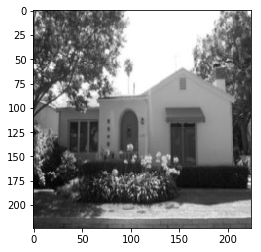

In [23]:
images1 = inputs1[0].numpy()
print(images1.shape)
images1 = np.transpose(images1,[1,2,0])
print(images1.shape)
# plt.subplot(121)
plt.imshow(images1)

In [24]:
def imshow(inp, name):
    """Imshow for Tensor."""
    inp = inp.detach().cpu().numpy()
    inp = np.transpose(inp,[1,2,0])#widthxheightxchannels

    n_features = inp.shape[-1]
    size = inp.shape[0]
    images_per_row = 16
    n_cols = n_features // images_per_row
    
    display_grid = np.zeros((size*n_cols, images_per_row*size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = inp[:,:, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col*size : (col +1) * size, 
                        row * size : (row + 1) * size]=channel_image
    scale = 1./size
    plt.figure(figsize = (scale * display_grid.shape[1],
                         scale * display_grid.shape[0]))
    plt.title(name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='gray')

/home/lee/anaconda3/envs/pytorch1/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/lee/anaconda3/envs/pytorch1/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


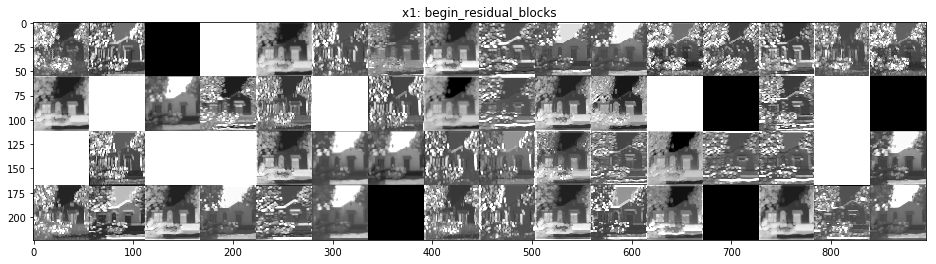

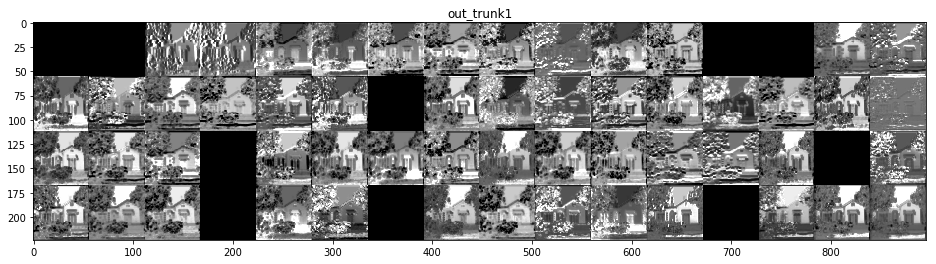

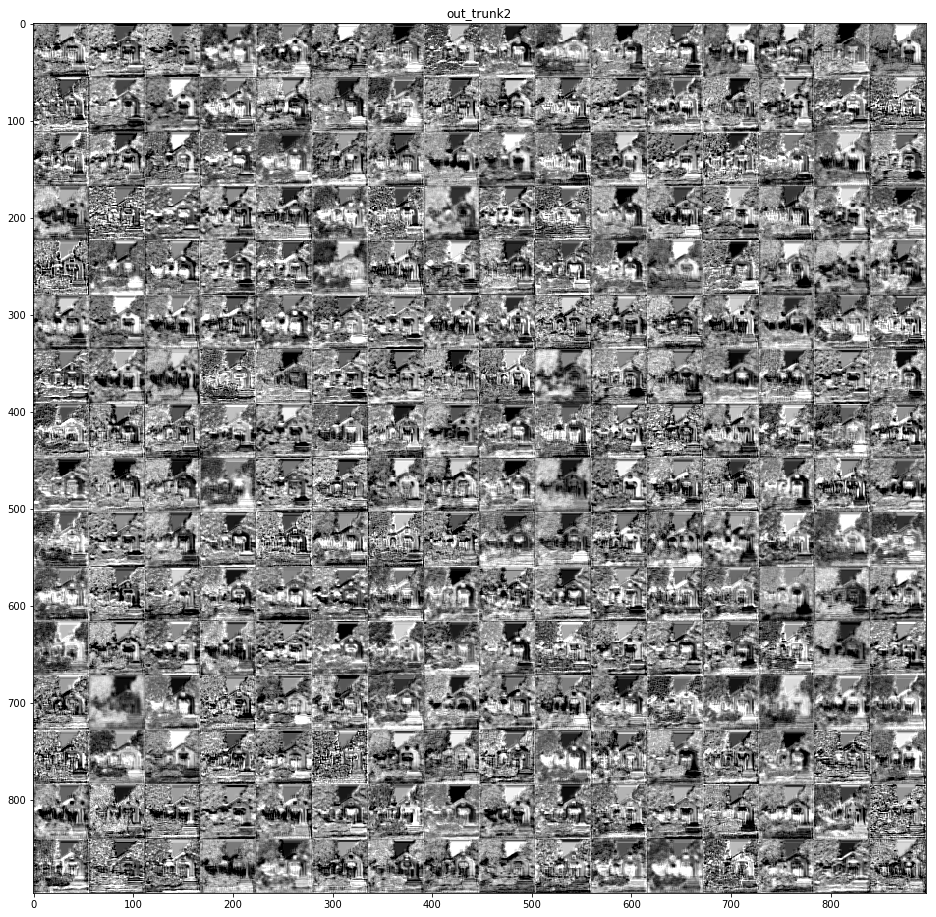

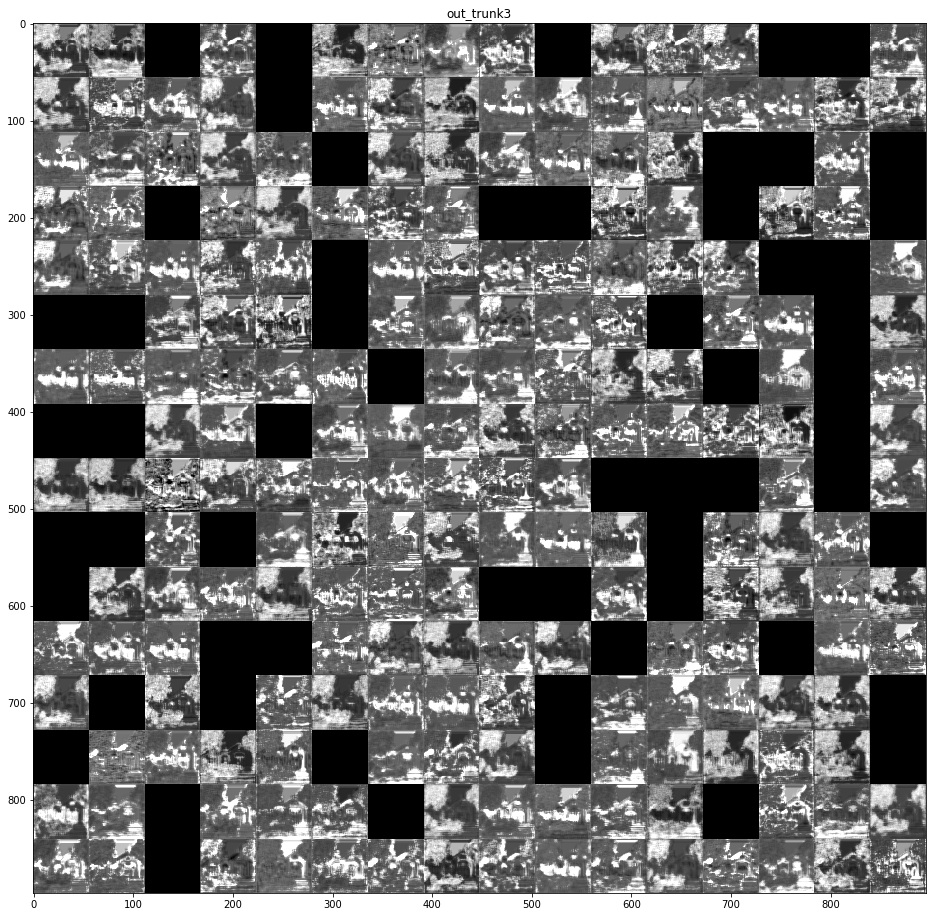

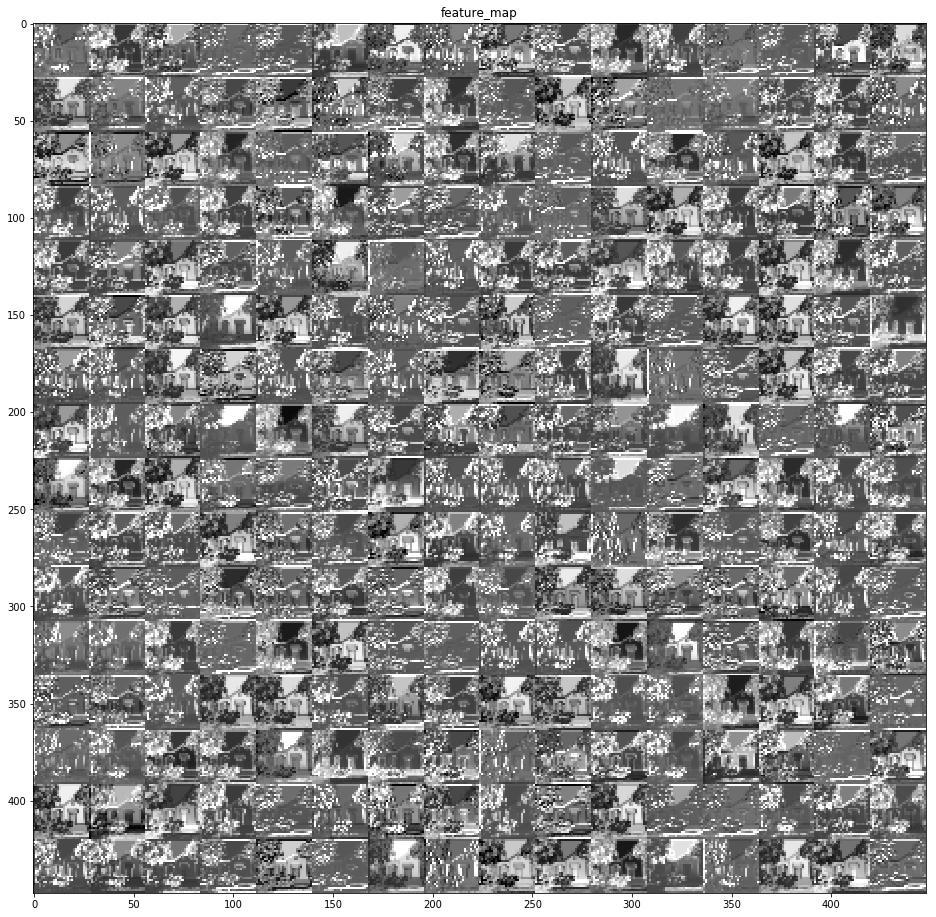

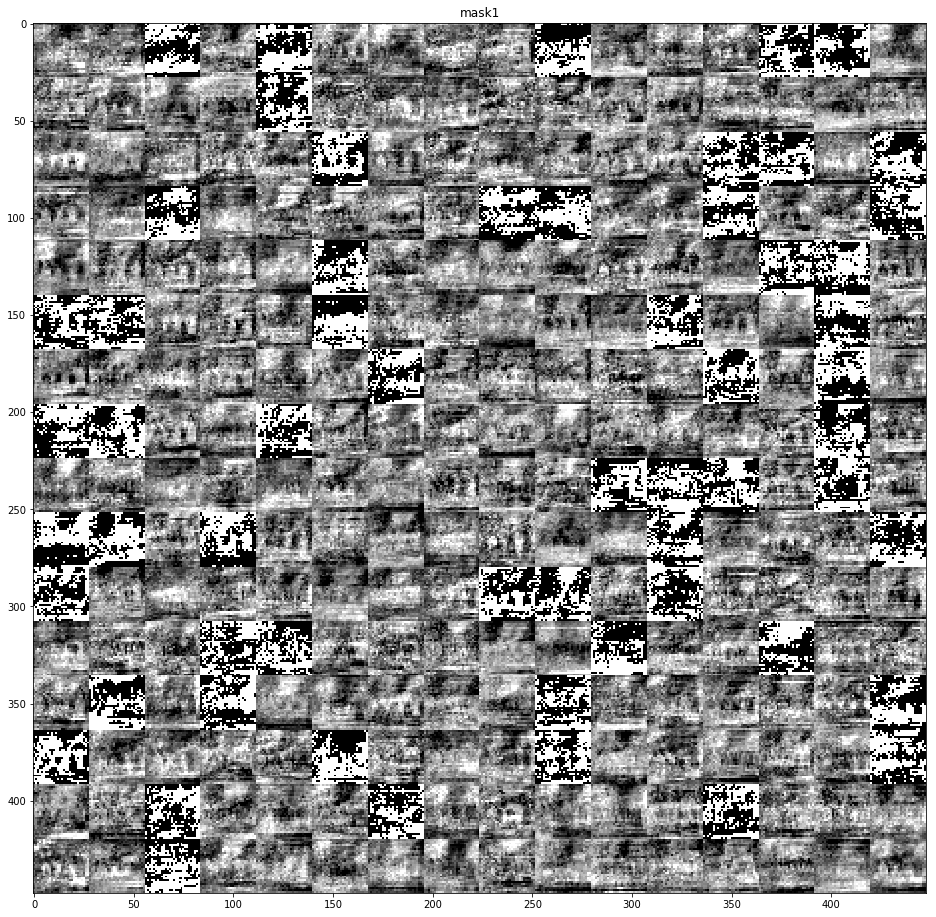

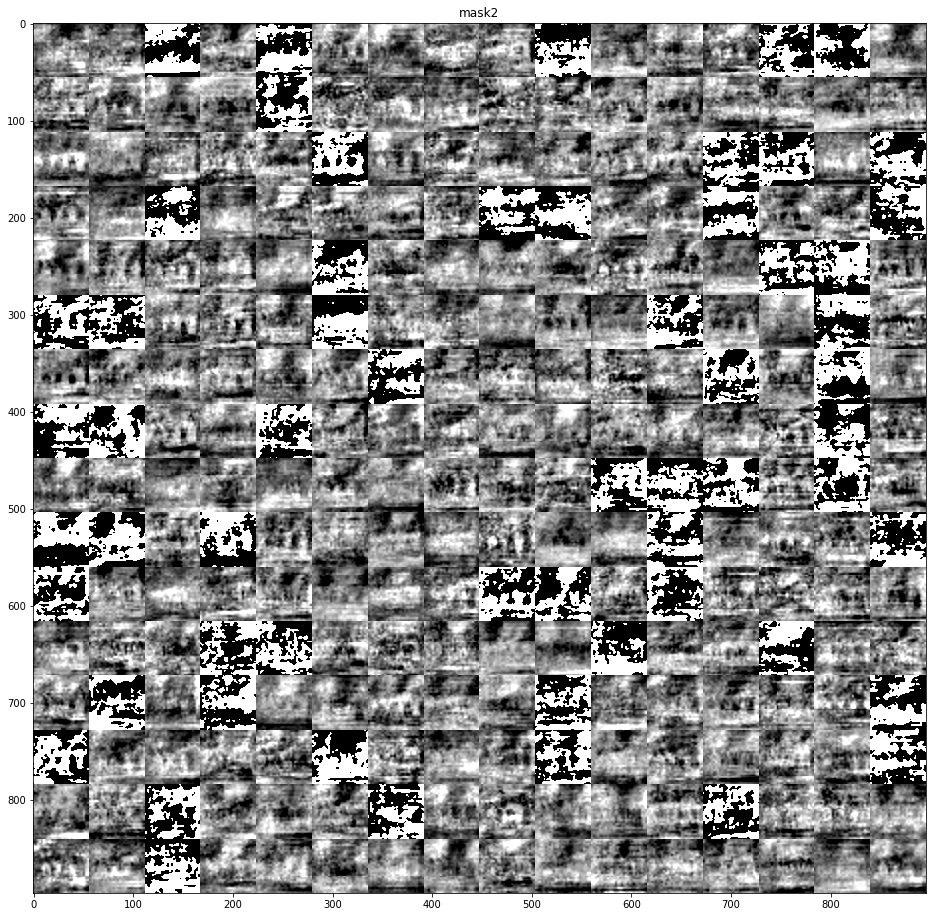

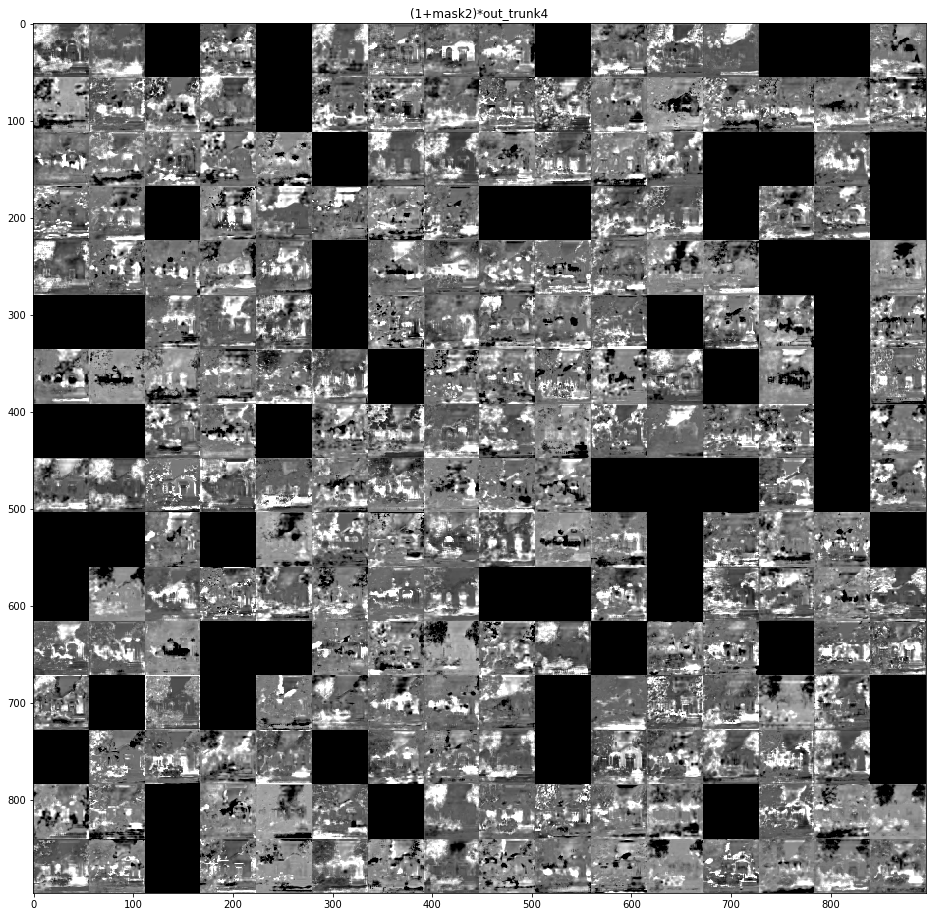

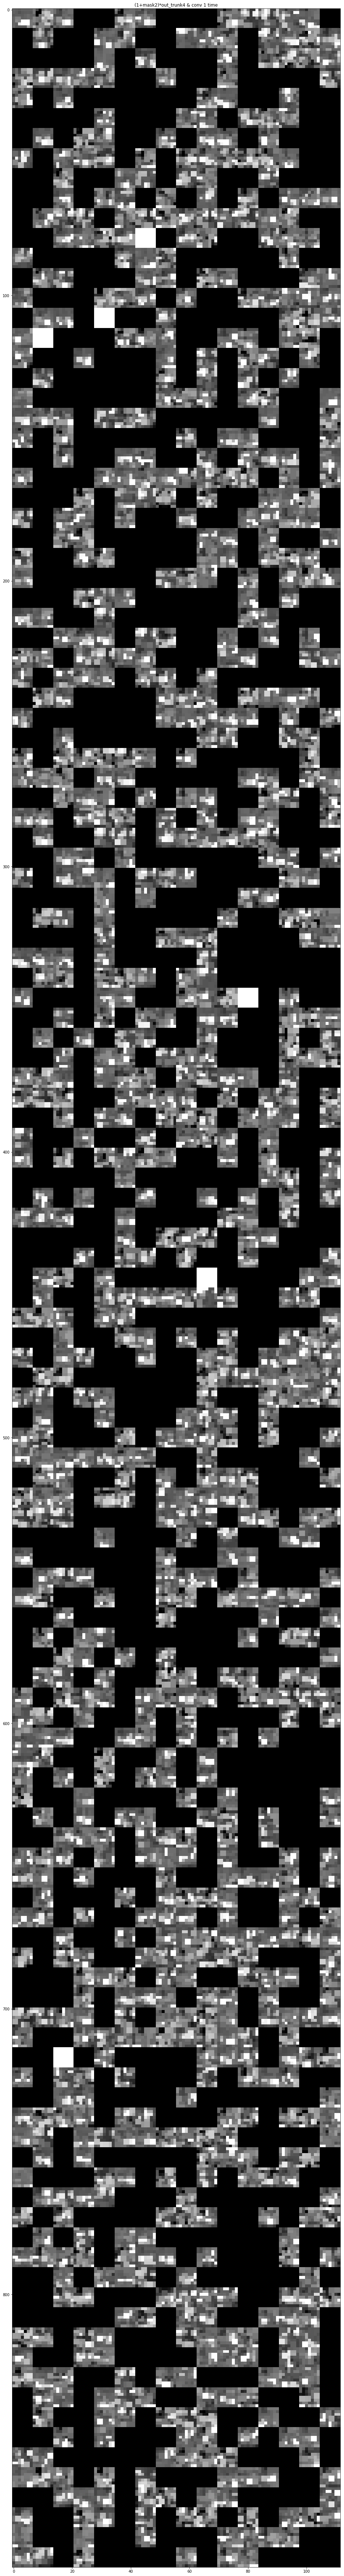

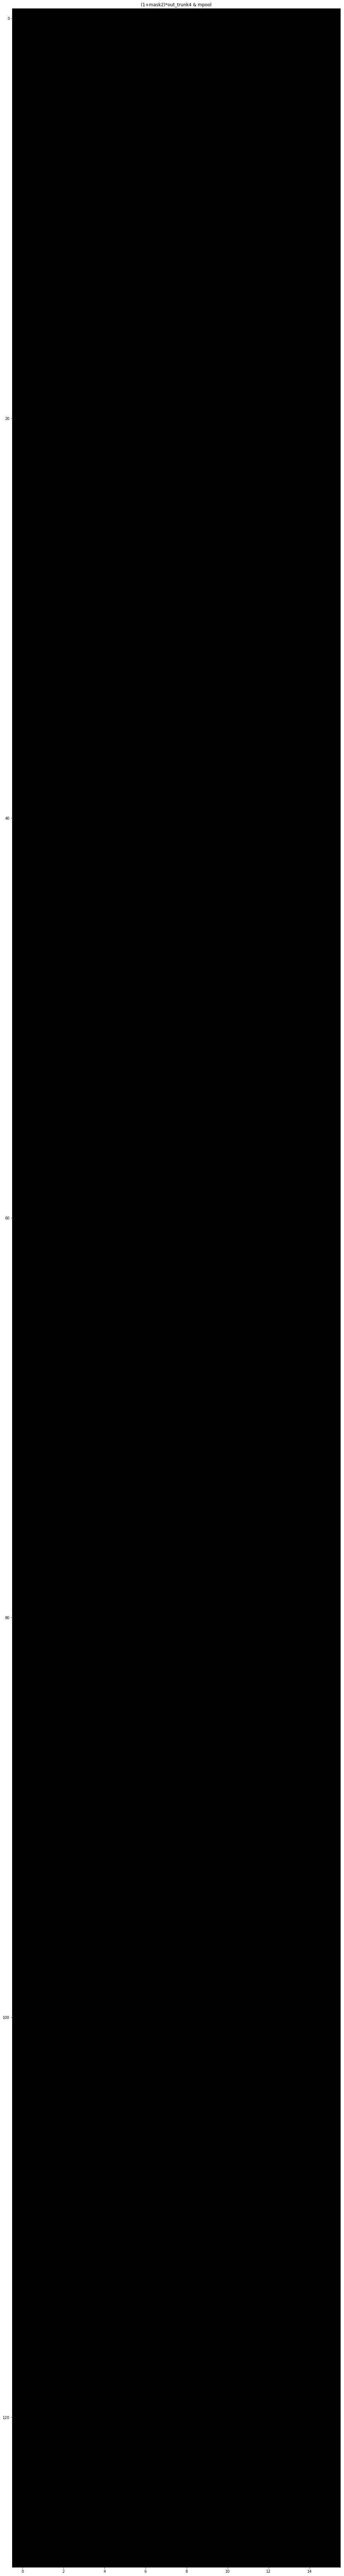

In [25]:
inputs1 = Variable(inputs1.cuda())

out1, out2, out3, out4, out5, out6, out7, out8, out9, out10, out11, out12= model(inputs1)
# out, x1, out_trunk1, out_trunk2, out_trunk3, feature_map, mask1, mask2, out1, out2, out3, out4 = model(inputs1)
# print(out1[0].shape)
# print(out2[0].shape)
# print(out3[0].shape)
# print(out4[0].shape)
# print(out5[0].shape)
# print(out6[0].shape)
# print(out7[0].shape)
# print(out8[0].shape)
# print(out9[0].shape)
# print(out10[0].shape)
# print(out11[0].shape)
# print(out12[0].shape)
conv1 = out1[0]
conv2 = out2[0]
conv3 = out3[0]
conv4 = out4[0]
conv5 = out5[0]
conv6 = out6[0]
conv7 = out7[0]
conv8 = out8[0]
conv9 = out9[0]
conv10 = out10[0]
conv11 = out11[0]
conv12 = out12[0]
# print(conv4.shape[0])
# print("50 classes")
# imshow(conv1)
name = "x1: begin_residual_blocks"
imshow(conv2, name)
name = "out_trunk1"
imshow(conv3, name)
name = "out_trunk2"
imshow(conv4, name)
name = "out_trunk3"
imshow(conv5, name)
name = "feature_map"
imshow(conv6, name)
name = "mask1"
imshow(conv7, name)
name = "mask2"
imshow(conv8, name)
name = "(1+mask2)*out_trunk4"
imshow(conv9, name)
name = "(1+mask2)*out_trunk4 & conv 1 time"
imshow(conv10, name)
name = "(1+mask2)*out_trunk4 & mpool"
imshow(conv11, name)
# print("flatten")
# imshow(conv12)

In [10]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [11]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [12]:
criterion = nn.CrossEntropyLoss()
def test(model3, criterion):
    

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for phase in ['test','valid']:
            print(phase)
            batch_time = AverageMeter()
            losses = AverageMeter()
            top1 = AverageMeter()
            top5 = AverageMeter()
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                if model3.cuda:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                inputs, labels = Variable(inputs, volatile=True), Variable(labels)

                # compute output
                outputs, x1, out_trunk1, out_trunk2, out_trunk3, feature_map, mask1, mask2, out1, out2, out3, out4 = model(inputs)
                loss = criterion(outputs, labels)

                # measure accuracy and record loss
                acc1, acc5 = accuracy(outputs, labels, topk=(1, 3))
                losses.update(loss.item(), inputs.size(0))
                top1.update(acc1[0], inputs.size(0))
                top5.update(acc5[0], inputs.size(0))

                # measure elapsed time
                batch_time.update(time.time() - end)
                end = time.time()

                if i % 10 == 0:
                    print('Test: [{0}/{1}]\t'
                          'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                          'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                          'Acc@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                          'Acc@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                           i, len(dataloaders[phase]), batch_time=batch_time, loss=losses,
                           top1=top1, top5=top5))
            
            print(' * Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
                  .format(top1=top1, top5=top5))
            

    return top1.avg

In [21]:
test(model,criterion)

test


/home/lee/anaconda3/envs/pytorch1/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Test: [0/450]	Time 0.663 (0.663)	Loss 2.2641 (2.2641)	Acc@1 0.000 (0.000)	Acc@5 0.000 (0.000)
Test: [10/450]	Time 0.048 (0.076)	Loss 1.0161 (0.7212)	Acc@1 0.000 (63.636)	Acc@5 100.000 (81.818)
Test: [20/450]	Time 0.027 (0.046)	Loss 0.0020 (0.6096)	Acc@1 100.000 (76.190)	Acc@5 100.000 (85.714)
Test: [30/450]	Time 0.058 (0.037)	Loss 0.0044 (0.7140)	Acc@1 100.000 (74.194)	Acc@5 100.000 (90.323)
Test: [40/450]	Time 0.017 (0.033)	Loss 1.1243 (0.6039)	Acc@1 0.000 (78.049)	Acc@5 100.000 (92.683)
Test: [50/450]	Time 0.058 (0.030)	Loss 0.0178 (0.5536)	Acc@1 100.000 (80.392)	Acc@5 100.000 (94.118)
Test: [60/450]	Time 0.005 (0.027)	Loss 0.0032 (0.5514)	Acc@1 100.000 (80.328)	Acc@5 100.000 (93.443)
Test: [70/450]	Time 0.060 (0.026)	Loss 0.0014 (0.5106)	Acc@1 100.000 (81.690)	Acc@5 100.000 (94.366)
Test: [80/450]	Time 0.003 (0.025)	Loss 1.0678 (0.5284)	Acc@1 100.000 (82.716)	Acc@5 100.000 (93.827)
Test: [90/450]	Time 0.069 (0.025)	Loss 0.0032 (0.5012)	Acc@1 100.000 (84.615)	Acc@5 100.000 (94.505)
T

tensor(80.5556, device='cuda:0')